Import Necessary Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np
import geopandas as gpd
from tqdm import tqdm
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns

# ETL (Extract, Transform, Load)

## Load and explore the dataset

### Geothermal Gradients Dataset

In [ ]:
gradients = pd.read_excel('data/Anexo 1. GRADIENTES GEOTÉRMICOS APARENTES.xlsx',sheet_name=1)
gradients = gradients.rename(columns={"Longitud": "Lon", "Latitud": "Lat"})
gradients.head()

### Moho Depth Dataset

In [ ]:
moho_depth = pd.read_csv('data/south-american-moho.txt', delim_whitespace=True, comment="#", header=None, names=["Latitude", "Longitude", "Moho Depth (m)"])
moho_depth = moho_depth.rename(columns={"Longitude": "Lon", "Latitude": "Lat"})
moho_depth.head()

## Data Preprocessing

### Moho Depth

We need to convert the Longitude from 0, 360° to -180°, 180°

In [ ]:
moho_depth["Lon"] = moho_depth["Lon"].apply(lambda x: x - 360 if x > 180 else x)

moho_depth.head()

Crop the moho_depth dataset so that it fits within the spatial extent of the first dataset (geothermal gradient).

In [ ]:
# Define the spatial extent boundaries from the "gradients" dataset
min_lon, max_lon = -79, -66
min_lat, max_lat = -4, 13

# Crop the "moho_depth" dataset to fit within the spatial extent of the "gradients" dataset
moho_depth= moho_depth[
    (moho_depth["Lat"] >= min_lat) & (moho_depth["Lat"] <= max_lat) &
    (moho_depth["Lon"] >= min_lon) & (moho_depth["Lon"] <= max_lon)
]

moho_depth.head()

In [ ]:
missing_values = moho_depth.isnull().sum()
missing_values

### Gradients

In [ ]:
# Check for missing values
missing_values = gradients.isnull().sum()
missing_values

Remove rows without geothermal gradient, latitude or longitude values

In [ ]:
gradients = gradients.dropna(subset=["Gradiente Geotérmico Aparente (°C/Km)"])
gradients = gradients.dropna(subset=["Lat", "Lon"])

gradients.tail()

In [ ]:
missing_values = gradients.isnull().sum()
missing_values

In [ ]:
for col in gradients.columns:
    print(col)

## Feature Engineering V1

### Moho Depth

In [ ]:
from scipy.interpolate import griddata

# Load the "gradients" and "moho_depth" datasets into GeoDataFrames
gradients_gdf = gpd.GeoDataFrame(gradients, geometry=gpd.points_from_xy(gradients['Lon'], gradients['Lat']))
moho_depth_gdf = gpd.GeoDataFrame(moho_depth, geometry=gpd.points_from_xy(moho_depth['Lon'], moho_depth['Lat']))

# Convert GeoDataFrames to numpy arrays
gradients_array = gradients_gdf[['Lon', 'Lat']].values
moho_depth_array = moho_depth_gdf[['Lon', 'Lat', 'Moho Depth (m)']].values

# Separate the coordinates and values
coordinates, values = moho_depth_array[:, :2], moho_depth_array[:, 2]

# Initialize tqdm for progress bar
pbar = tqdm(total=len(gradients_array), desc="Interpolating", ncols=100)

# Initialize an empty list to store interpolated Moho depth values for each well
moho_depth_values = []

# Iterate through each well
for gradient in gradients_array:
    # Use griddata for interpolation
    moho_depth_value = griddata(coordinates, values, [gradient], method='cubic')
    
    # Append the interpolated Moho depth value to the list
    moho_depth_values.append(moho_depth_value[0])
    
    # Update the progress bar
    pbar.update()

# Close the progress bar
pbar.close()

# Add the interpolated Moho depth values to the "gradients" dataset as a new column
gradients['Moho_Depth (m)'] = moho_depth_values

In [ ]:
gradients.head()

### Magnetic anomaly

In [ ]:
src = rasterio.open('data/Mag_anom_col.tif')

# Print the CRS
print(src.crs)

In [ ]:
import rasterio
from rasterio.warp import transform

# Load the TIFF file
src = rasterio.open('data/Mag_anom_col.tif')

# Define a function to get the value from the TIFF file
def get_value_from_tiff(lat, lon):
    # Adjust longitudes greater than 180
    if lon > 180:
        lon = lon - 360
    # Transform lat, lon to the coordinate system of the tiff
    x, y = transform('EPSG:4326', src.crs, [lon], [lat])
    # Get the value at the transformed coordinate
    for val in src.sample([(x[0], y[0])]):
        return val[0]

# Apply the function to each row in the dataframe
gradients['Magnetic Anomaly (nT)'] = gradients.apply(lambda row: get_value_from_tiff(row['Lat'], row['Lon']), axis=1)

In [ ]:
gradients.head()

## Dataset cleaning

In [ ]:
# Replace "\n" with a space in column names
gradients.columns = gradients.columns.str.replace('\n', ' ')

In [ ]:
gradients.columns = gradients.columns.str.replace('  ', ' ')
gradients.columns = gradients.columns.str.replace('   ', ' ')

In [ ]:
# Convert "Profundidad BHT (ft)" to meters (1 ft = 0.3048 m)
gradients['Profundidad BHT (m)'] = gradients['Profundidad BHT (ft)'] * 0.3048

In [ ]:
gradients.columns

Select and rename columns

In [ ]:
columns_to_remove = ['UWI', 'Nombre del Pozo', 'Profundidad Total (ft)', 'Departamento', 'Cuenca', 'Coordenada X', 'Coordenada  Y', 'Elevación GL (ft)', 'BHT (°F)', 'BHT (°C)', 'Profundidad BHT (ft)', 'Profundidad BHT (m)', 'Temperatura de formación (°C)', 'Año de actualizacion del dato']

cleaned_data = gradients.drop(columns=columns_to_remove)

In [ ]:
# Create a dictionary to map the Spanish column names to English column names
column_name_mapping = {
    'Lat': 'Latitude',
    'Lon': 'Longitude',
    'Elevacion (m)': 'Elevation (m)',
    'Temperatura en superficie (°C)': 'Surface Temperature (°C)',
    'Gradiente Geotérmico Aparente (°C/Km)': 'Apparent Geothermal Gradient (°C/Km)',
    'Moho_Depth (m)': 'Moho Depth (m)',
}

# Rename the columns using the dictionary
cleaned_data = cleaned_data.rename(columns=column_name_mapping)

In [ ]:
cleaned_data.to_csv('cleaned_data_beforeoutliers.csv', index=False)

In [ ]:
cleaned_data = pd.read_csv('cleaned_data_beforeoutliers.csv')

Remove magnetic anomaly outliers

In [ ]:
# Filter the DataFrame
cleaned_data = cleaned_data[(cleaned_data['Magnetic Anomaly (nT)'] >= -363.13598632812) & 
                             (cleaned_data['Magnetic Anomaly (nT)'] <= 548.34930419922)]


In [ ]:
sns.histplot(cleaned_data['Magnetic Anomaly (nT)'], kde=False)

In [ ]:
# Save the DataFrame to a new CSV file
cleaned_data.to_csv('cleaned_data.csv', index=False)

## Check data distribution

In [ ]:
cleaned_data = pd.read_csv('cleaned_data.csv')

In [ ]:
sns.histplot(cleaned_data['Apparent Geothermal Gradient (°C/Km)'], kde=False)

In [ ]:
cleaned_data.head()

## Feature Engineering V2

### Add fault proximity

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points
from tqdm import tqdm  # Import tqdm for the progress bar
import pandas as pd

# Load the shapefile
faults = gpd.read_file('data/Faults/faults.shp')

# Ensure the shapefile is in the correct coordinate system
faults = faults.to_crs('EPSG:3116')

# Create a GeoDataFrame from your dataset
# Replace 'Latitude' and 'Longitude' with your actual column names
gdf = gpd.GeoDataFrame(cleaned_data, geometry=gpd.points_from_xy(cleaned_data.Longitude, cleaned_data.Latitude), crs='EPSG:4326')

# Convert the GeoDataFrame to the same coordinate system as the shapefile
gdf = gdf.to_crs('EPSG:3116')

# Initialize an empty GeoDataFrame to store the distances
distances = gpd.GeoDataFrame()

# Loop through each point in the GeoDataFrame with tqdm for the progress bar
for index, row in tqdm(gdf.iterrows(), total=len(gdf), desc="Calculating Nearest Faults"):
    # Find the nearest fault of each type for the current point
    nearest_fault = {}
    for fault_type in faults['Tipo'].unique():
        faults_of_type = faults[faults['Tipo'] == fault_type].copy()
        faults_of_type['geometry'] = faults_of_type['geometry'].centroid
        faults_of_type = faults_of_type.set_geometry('geometry')
        faults_of_type = faults_of_type.unary_union
        nearest = nearest_points(row['geometry'], faults_of_type)[1]
        nearest_fault[fault_type] = nearest.distance(row['geometry'])
    # Append the nearest faults to the GeoDataFrame
    distances = pd.concat([distances, gpd.GeoDataFrame(nearest_fault, index=[index])])

# Add the new columns to the original DataFrame
cleaned_data = pd.concat([cleaned_data, distances], axis=1)

In [ ]:
cleaned_data.columns

Each fault has 2 additional sub-types: "cubierta" and "inferida", so let's compute the nearest among the three and leave each fault type as a single column.

In [ ]:
# List of fault types including "Lineamiento"
fault_types = ['Falla', 'Falla de rumbo sinestral', 'Falla inversa o de cabalgamiento', 'Lineamiento', 'Falla de rumbo dextral', 'Falla normal']

# Iterate through each fault type
for fault_type in fault_types:
    # Skip the consolidation process for "Lineamiento"
    if fault_type == 'Lineamiento':
        continue
    
    # Create a new column with the minimum distance among the original, 'cubierta', and 'inferida' columns
    cleaned_data[fault_type] = cleaned_data[[f'{fault_type} cubierta', f'{fault_type} inferida', fault_type]].min(axis=1)

    # Drop the redundant 'cubierta' and 'inferida' columns
    cleaned_data = cleaned_data.drop([f'{fault_type} cubierta', f'{fault_type} inferida'], axis=1)

In [ ]:
cleaned_data.columns

In [ ]:
# Define a mapping of old column names to new column names
column_mapping = {
    'Falla': 'Fault',
    'Falla de rumbo sinestral': 'Strike-slip Fault',
    'Falla inversa o de cabalgamiento': 'Reverse or Thrust Fault',
    'Lineamiento': 'Lineament',
    'Falla de rumbo dextral': 'Right-lateral Fault',
    'Falla normal': 'Normal Fault'
}


# Rename columns
cleaned_data.rename(columns=column_mapping, inplace=True)

In [ ]:
cleaned_data.to_csv('cleaned_faults.csv', index=False)

In [ ]:
cleaned_data = pd.read_csv('cleaned_faults.csv')
cleaned_data.head()

### Active faults

In [ ]:
import geopandas as gpd
from shapely.ops import nearest_points
from tqdm import tqdm
import pandas as pd

# Load the active faults shapefile
active_faults_path = 'data/Faults/Active/ATA.shp'
active_faults = gpd.read_file(active_faults_path)
active_faults = active_faults.to_crs('EPSG:3116')


# Create a GeoDataFrame from your dataset
# Replace 'Latitude' and 'Longitude' with your actual column names
gdf = gpd.GeoDataFrame(cleaned_data, geometry=gpd.points_from_xy(cleaned_data.Longitude, cleaned_data.Latitude), crs='EPSG:4326')

# Convert the GeoDataFrame to the same coordinate system as the active faults
gdf = gdf.to_crs(active_faults.crs)

# Initialize an empty DataFrame to store distances to active faults
active_faults_distances = pd.DataFrame()

# Loop through each point in the GeoDataFrame with tqdm for the progress bar
for index, row in tqdm(gdf.iterrows(), total=len(gdf), desc="Calculating Distances to Active Faults"):
    # Find the nearest active fault for the current point
    nearest_active_fault = nearest_points(row['geometry'], active_faults.unary_union)[1]
    
    # Calculate the distance and store it in the DataFrame
    distance_to_active_fault = nearest_active_fault.distance(row['geometry'])
    active_faults_distances.at[index, 'Active Fault'] = distance_to_active_fault

# Add the new column to the original DataFrame
cleaned_data = pd.concat([cleaned_data, active_faults_distances], axis=1)

In [ ]:
cleaned_data.to_csv('cleaned_faults.csv', index=False)

In [ ]:
cleaned_data = pd.read_csv('cleaned_faults.csv')
cleaned_data.head()

### Curie Depth

In [ ]:
src = rasterio.open('data/Curie_depth.tif')

# Print the CRS
print(src.crs)

In [ ]:
import rasterio
from rasterio.warp import transform

# Load the TIFF file
src = rasterio.open('data/Curie_depth.tif')

# Define a function to get the value from the TIFF file
def get_value_from_tiff(lat, lon):
    # Adjust longitudes greater than 180
    if lon > 180:
        lon = lon - 360
    # Transform lat, lon to the coordinate system of the tiff
    x, y = transform('EPSG:4326', src.crs, [lon], [lat])
    # Get the value at the transformed coordinate
    for val in src.sample([(x[0], y[0])]):
        return val[0]

# Apply the function to each row in the dataframe
cleaned_data['Curie Depth (Km)'] = cleaned_data.apply(lambda row: get_value_from_tiff(row['Latitude'], row['Longitude']), axis=1)

In [ ]:
cleaned_data.head()

### Vertical Gravity Gradient

In [ ]:
src = rasterio.open('data/colombia_gravity_map.tif')

# Print the CRS
print(src.crs)

In [ ]:
import rasterio
from rasterio.warp import transform

# Load the TIFF file
src = rasterio.open('data/colombia_gravity_map.tif')

# Define a function to get the value from the TIFF file
def get_value_from_tiff(lat, lon):
    # Adjust longitudes greater than 180
    if lon > 180:
        lon = lon - 360
    # Transform lat, lon to the coordinate system of the tiff
    x, y = transform('EPSG:4326', src.crs, [lon], [lat])
    # Get the value at the transformed coordinate
    for val in src.sample([(x[0], y[0])]):
        return val[0]

# Apply the function to each row in the dataframe
cleaned_data['Gravity_gradient'] = cleaned_data.apply(lambda row: get_value_from_tiff(row['Latitude'], row['Longitude']), axis=1)

In [ ]:
cleaned_data.head()

### Free Air Anomaly

In [ ]:
src = rasterio.open('data/colombia_FAA_map.tif')

# Print the CRS
print(src.crs)

In [ ]:
import rasterio
from rasterio.warp import transform

# Load the TIFF file
src = rasterio.open('data/colombia_FAA_map.tif')

# Define a function to get the value from the TIFF file
def get_value_from_tiff(lat, lon):
    # Adjust longitudes greater than 180
    if lon > 180:
        lon = lon - 360
    # Transform lat, lon to the coordinate system of the tiff
    x, y = transform('EPSG:4326', src.crs, [lon], [lat])
    # Get the value at the transformed coordinate
    for val in src.sample([(x[0], y[0])]):
        return val[0]

# Apply the function to each row in the dataframe
cleaned_data['FAA'] = cleaned_data.apply(lambda row: get_value_from_tiff(row['Latitude'], row['Longitude']), axis=1)

In [ ]:
cleaned_data.head()

### Bouguer anomaly

In [ ]:
src = rasterio.open('data/bouguer_col.tif')

# Print the CRS
print(src.crs)

In [ ]:
import rasterio
from rasterio.warp import transform

# Load the TIFF file
src = rasterio.open('data/bouguer_col.tif')

# Define a function to get the value from the TIFF file
def get_value_from_tiff(lat, lon):
    # Adjust longitudes greater than 180
    if lon > 180:
        lon = lon - 360
    # Transform lat, lon to the coordinate system of the tiff
    x, y = transform('EPSG:4326', src.crs, [lon], [lat])
    # Get the value at the transformed coordinate
    for val in src.sample([(x[0], y[0])]):
        return val[0]

# Apply the function to each row in the dataframe
cleaned_data['Bouguer'] = cleaned_data.apply(lambda row: get_value_from_tiff(row['Latitude'], row['Longitude']), axis=1)

In [ ]:
cleaned_data.head()

In [ ]:
cleaned_data.rename(columns={
        'Gravity_gradient': 'Vertical Gravity Gradient (E)',
        'FAA': 'Free Air Anomaly (mGal)',
        'Bouguer': 'Bouguer Anomaly (mGal)'}, inplace=True)

In [ ]:
cleaned_data.to_csv('data_pre_norm.csv')

In [ ]:
cleaned_data.columns

## Normalization of the data

Input data needs to be normalized as the features are in different scales. Target (heat flow) is not being normalized.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

columns_to_normalize = ['Elevation (m)', 'Surface Temperature (°C)',
       'Moho Depth (m)', 'Curie Depth (Km)', 'Fault', 'Strike-slip Fault',
       'Reverse or Thrust Fault', 'Lineament', 'Right-lateral Fault',
       'Normal Fault', 'Active Fault', 'Magnetic Anomaly (nT)',
       'Vertical Gravity Gradient (E)', 'Free Air Anomaly (mGal)',
       'Bouguer Anomaly (mGal)']

# Initialize the Min-Max scaler
scaler = MinMaxScaler()

# Fit and transform the selected columns
cleaned_data[columns_to_normalize] = scaler.fit_transform(cleaned_data[columns_to_normalize])

# Save the normalized data to a new CSV file
cleaned_data.to_csv('normalized_data_minmax.csv', index=False)

In [ ]:
cleaned_data.head()

## Read the normalized dataset

In [2]:
cleaned_data = pd.read_csv('normalized_data_minmax.csv')
cleaned_data.head()

,Latitude,Longitude,Elevation (m),Surface Temperature (°C),Apparent Geothermal Gradient (°C/Km),Moho Depth (m),Magnetic Anomaly (nT),Fault,Strike-slip Fault,Reverse or Thrust Fault,Lineament,Right-lateral Fault,Normal Fault,Active Fault,Curie Depth (Km),Vertical Gravity Gradient (E),Free Air Anomaly (mGal),Bouguer Anomaly (mGal)
0,4.213002,-74.893581,0.100752,0.899248,14.712281,0.720860,0.371683,0.055508,0.105702,0.021543,0.073640,0.100585,0.417515,0.035052,0.642857,0.341539,0.093121,0.241172
1,4.216078,-74.888898,0.100557,0.899443,21.294394,0.720455,0.371683,0.053527,0.104876,0.022877,0.075174,0.102181,0.418871,0.036250,0.642857,0.341539,0.093121,0.241172
2,4.214720,-74.891220,0.101535,0.898465,23.783404,0.720641,0.371683,0.054497,0.105307,0.022201,0.074422,0.101405,0.418205,0.035636,0.642857,0.341539,0.093121,0.241172
3,0.606276,-76.564731,0.088329,0.911671,24.156323,0.412171,0.524208,0.121886,0.170555,0.112310,0.283746,0.153212,0.761431,0.112189,0.357143,0.467743,0.309559,0.615321
4,0.305911,-76.914853,0.029052,0.970948,25.601245,0.483869,0.530678,0.126023,0.146573,0.097701,0.240410,0.232241,0.842979,0.105716,0.357143,0.460502,0.306293,0.628522


## Correlation Matrix

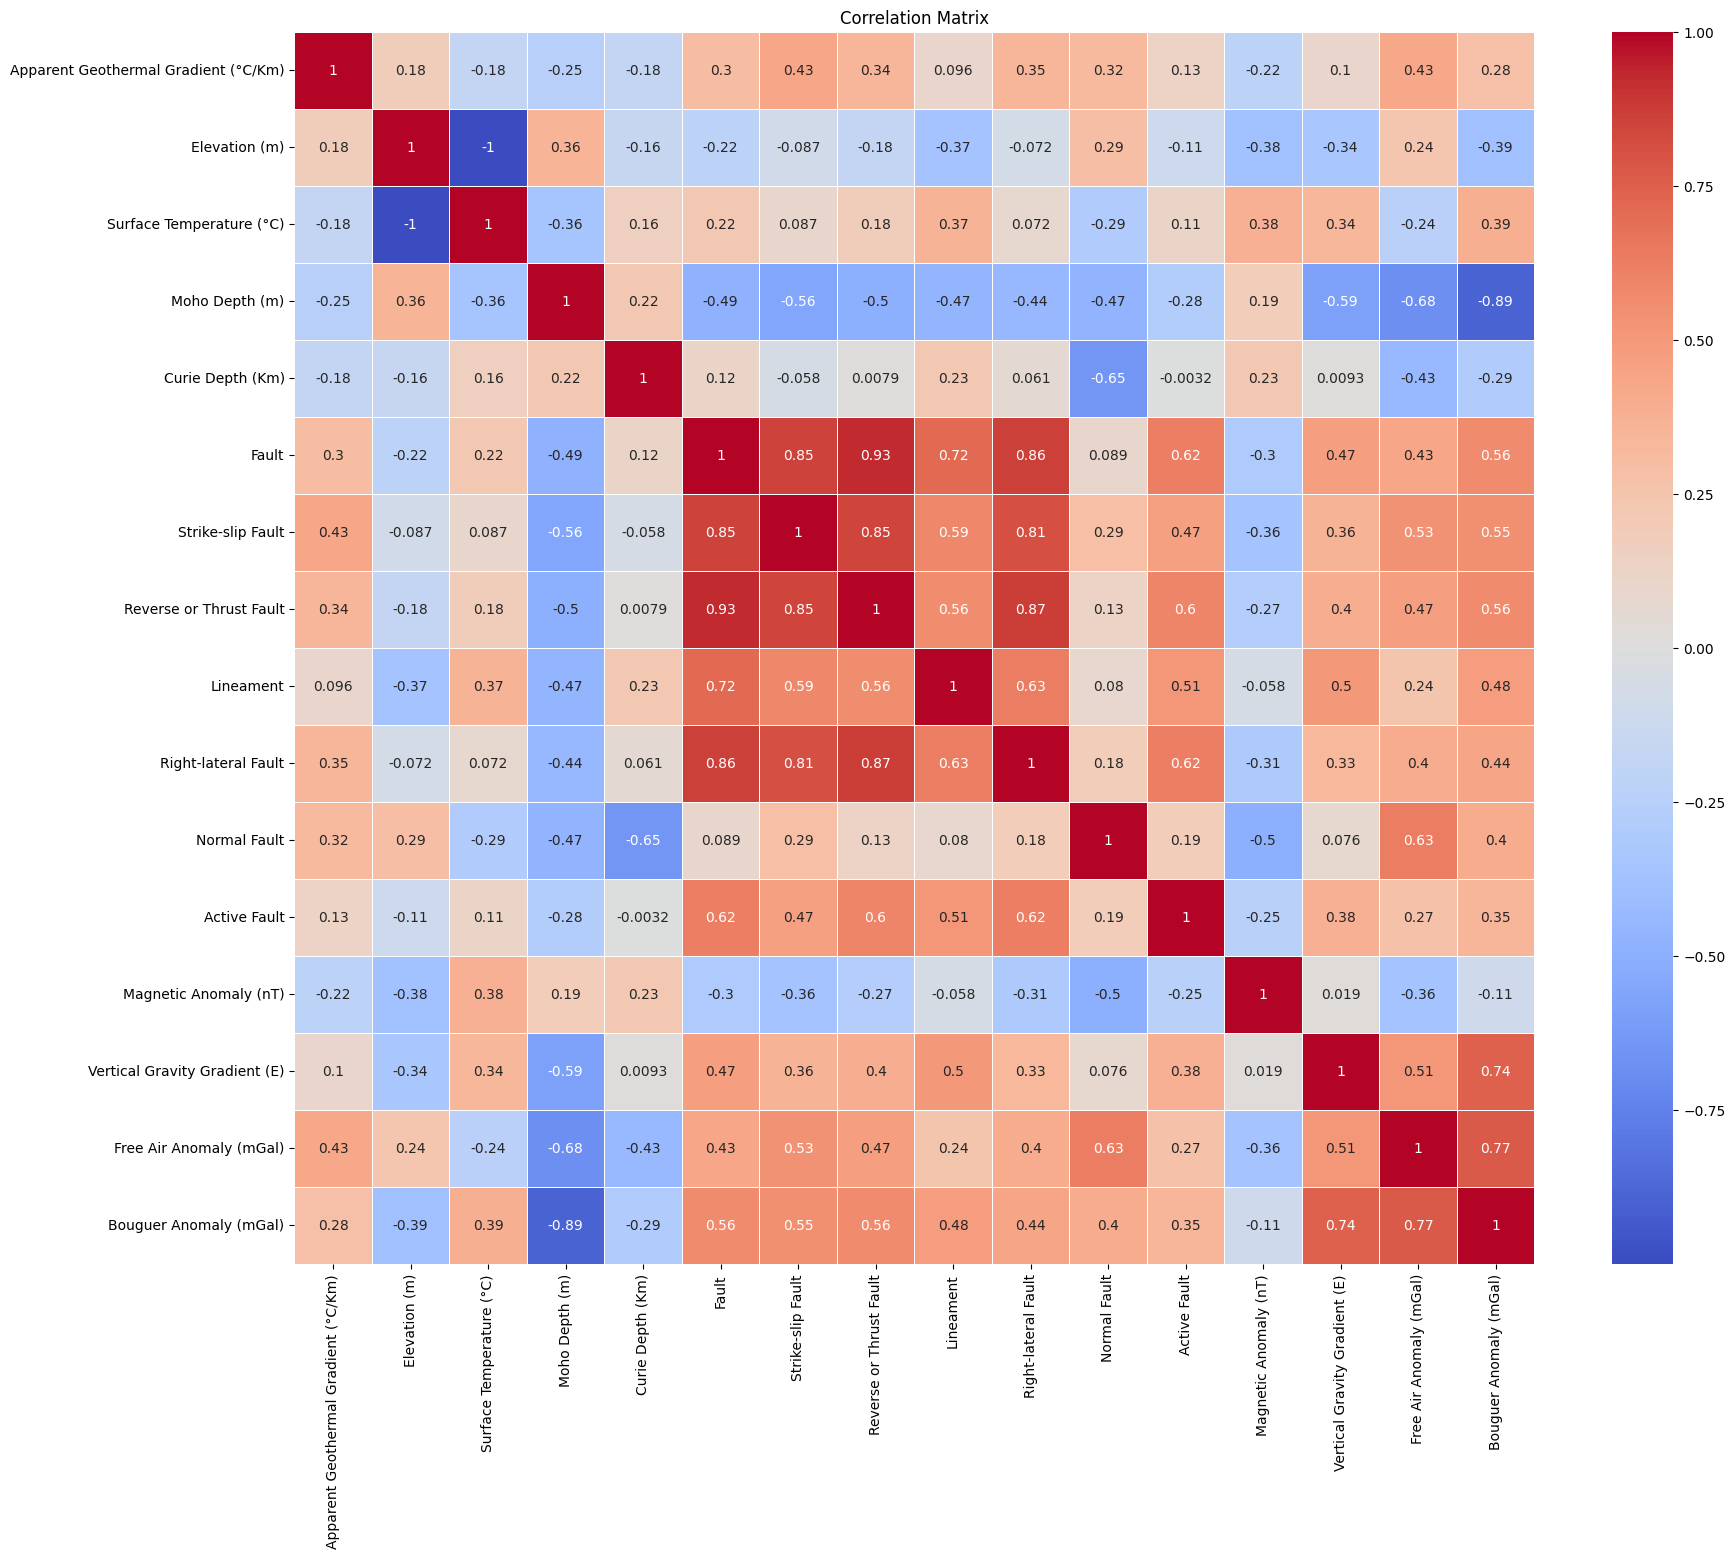

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the desired columns
selected_columns = ['Apparent Geothermal Gradient (°C/Km)', 
       'Elevation (m)', 'Surface Temperature (°C)',
       'Moho Depth (m)', 'Curie Depth (Km)', 'Fault', 'Strike-slip Fault',
       'Reverse or Thrust Fault', 'Lineament', 'Right-lateral Fault',
       'Normal Fault', 'Active Fault', 'Magnetic Anomaly (nT)',
       'Vertical Gravity Gradient (E)', 'Free Air Anomaly (mGal)',
       'Bouguer Anomaly (mGal)']

# Create a DataFrame with the selected columns
selected_data = cleaned_data[selected_columns]

# Calculate the correlation matrix
correlation_matrix = selected_data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


# Building Machine Learning Algorithm

## Data Splitting

In [4]:
cleaned_data.columns

Index(['Latitude', 'Longitude', 'Elevation (m)', 'Surface Temperature (°C)',
       'Apparent Geothermal Gradient (°C/Km)', 'Moho Depth (m)',
       'Magnetic Anomaly (nT)', 'Fault', 'Strike-slip Fault',
       'Reverse or Thrust Fault', 'Lineament', 'Right-lateral Fault',
       'Normal Fault', 'Active Fault', 'Curie Depth (Km)',
       'Vertical Gravity Gradient (E)', 'Free Air Anomaly (mGal)',
       'Bouguer Anomaly (mGal)'],
      dtype='object')

In [5]:
# Define feature matrix (X) and target variables (y)
X = cleaned_data[['Latitude', 'Longitude', 'Elevation (m)',
       'Curie Depth (Km)','Moho Depth (m)', 'Fault', 
       'Strike-slip Fault', 'Reverse or Thrust Fault', 
       'Lineament', 'Right-lateral Fault',
       'Normal Fault', 'Active Fault', 'Magnetic Anomaly (nT)',
       'Vertical Gravity Gradient (E)', 'Free Air Anomaly (mGal)',
       'Bouguer Anomaly (mGal)']]

y = cleaned_data['Apparent Geothermal Gradient (°C/Km)']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save X_test with lat and lon for plotting later
X_test_with_lat_lon = X_test[['Latitude', 'Longitude']].copy()

# Save X with lat and lon for plotting later
X_lat_lon = X[['Latitude', 'Longitude']].copy()

# Remove lat and lon from X to predict on the whole dataset
X = X.drop(['Latitude', 'Longitude'], axis=1)

#Remove lat and lon from X_train and X_test
X_train = X_train.drop(['Latitude', 'Longitude'], axis=1)
X_test = X_test.drop(['Latitude', 'Longitude'], axis=1)

# Create DMatrix objects for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

## Hyperparameter Tuning

Manually iterating over hyperparameter combinations and recording the progress using the tqdm library. 

In [6]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
import numpy as np
from tqdm import tqdm

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [5, 7, 10],
    'learning_rate': [0.1, 0.01],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10],
    'colsample_bytree': [0.5, 0.7, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 1.5, 2],
}

best_params = {}
best_mse = float('inf')

# Use tqdm to display a progress bar
total_combinations = len(list(ParameterGrid(param_grid)))
with tqdm(total=total_combinations) as pbar:
    for params in ParameterGrid(param_grid):
        xgb_model = xgb.XGBRegressor(**params)
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        if mse < best_mse:
            best_params = params
            best_mse = mse
        pbar.update(1)

print("Best Hyperparameters:", best_params)
print("Best Mean Squared Error:", best_mse)


100%|██████████| 1458/1458 [09:38<00:00,  2.52it/s]

Best Hyperparameters: {'colsample_bytree': 1, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 2}
Best Mean Squared Error: 23.246595137130903


In [ ]:
best_params = {'colsample_bytree': 1, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 2}

## Train XGBoost and evaluate model

In [7]:
best_xgb_model = xgb.XGBRegressor(**best_params)
best_xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.1, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Evaluate the model's performance on the test data using appropriate regression metrics (e.g., MAE, RMSE, R-squared).

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predictions on the training set
y_train_pred = best_xgb_model.predict(X_train)

# Metrics for the training set
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
r2_train = r2_score(y_train, y_train_pred)

# Predictions on the test set
y_test_pred = best_xgb_model.predict(X_test)

# Metrics for the test set
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_test = r2_score(y_test, y_test_pred)

# Print or use the metrics as needed
print("Training Set Metrics:")
print(f"MAE: {mae_train}")
print(f"RMSE: {rmse_train}")
print(f"R-squared: {r2_train}")
print("\nTest Set Metrics:")
print(f"MAE: {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"R-squared: {r2_test}")

Training Set Metrics:
MAE: 1.8272057180710033
RMSE: 2.7554129147762945
R-squared: 0.7878859749309692

Test Set Metrics:
MAE: 2.872491027648391
RMSE: 4.8214722997369694
R-squared: 0.40424553496470406


## Save the model

In [9]:
import joblib

In [10]:
joblib.dump(best_xgb_model, 'trained_model.pkl')

['trained_model.pkl']

# Visualization of results

In [11]:
y_pred = y_test_pred

## Residual Plot

Create a residual plot to check if the model's predictions have a pattern. Most residuals must be near to zero

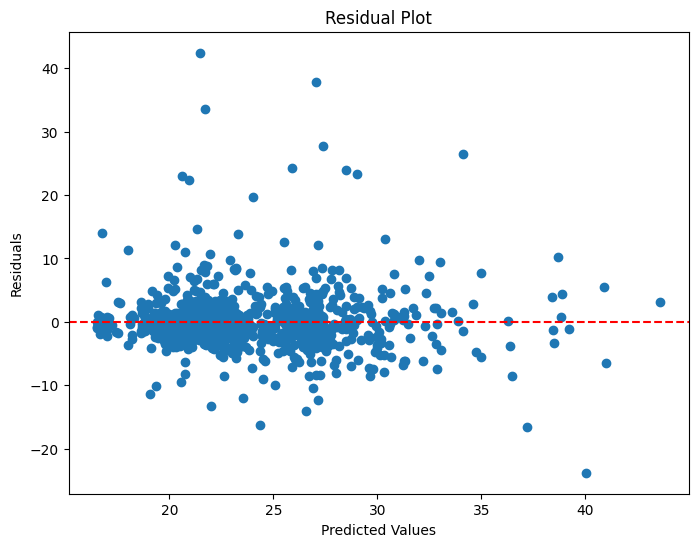

In [12]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.show()

## Actual vs. Predicted Plot

Visualize how model's predictions compare to the actual values.

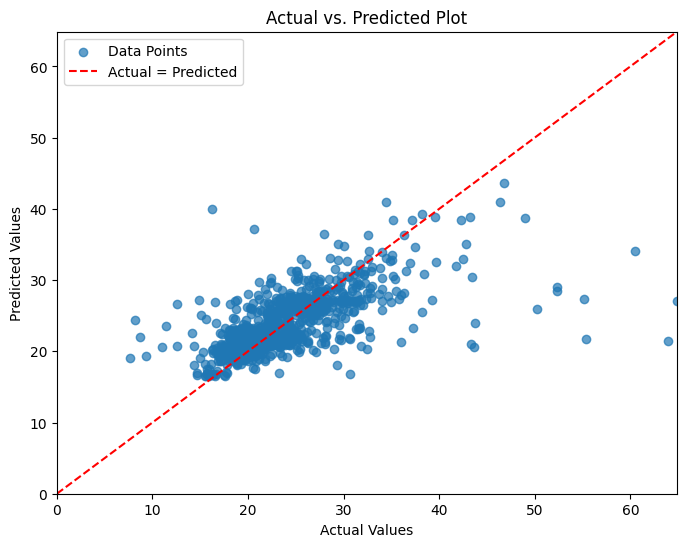

In [13]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, label='Data Points', alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Plot')

# Set x and y axis limits to start at 0,0
plot_max = max(max(y_test), max(y_pred))
plt.xlim(0, plot_max)
plt.ylim(0, plot_max)

# Plot the line where Actual = Predicted
plt.plot([0, plot_max], [0, plot_max], color='red', linestyle='--', label='Actual = Predicted')

plt.legend()
plt.show()

## Feature Importance Plot

Visualize the importance of each feature in the Random Forest model. This will help to understand which features have the most significant impact on predicting the geothermal gradient.

<Figure size 2000x3000 with 0 Axes>

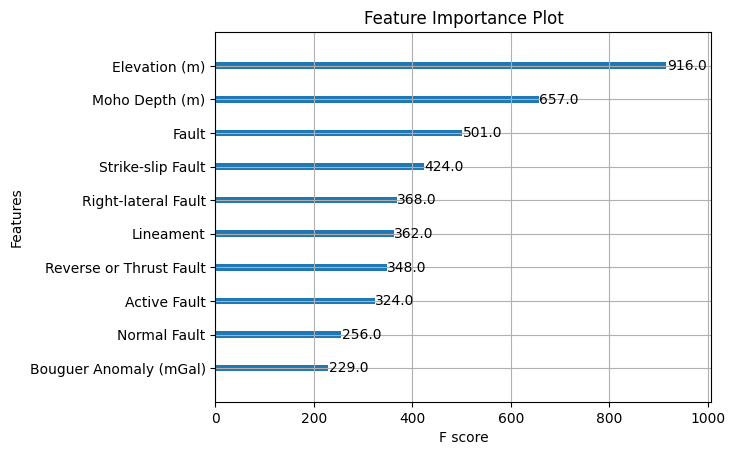

In [15]:
# Plot feature importance
plt.figure(figsize=(20, 30))
xgb.plot_importance(best_xgb_model, importance_type='weight', max_num_features=10)
plt.title('Feature Importance Plot')
plt.show()

## RFE & Permutation Importance

In [16]:
from xgboost import plot_importance
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Lasso
from sklearn.feature_selection import mutual_info_regression

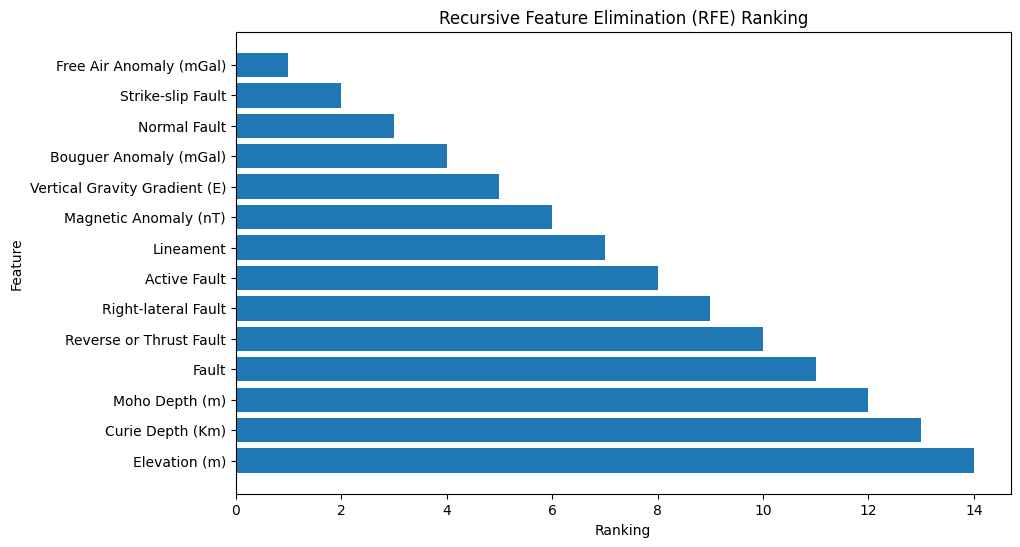

In [17]:
# Recursive Feature Elimination (RFE)
selector = RFE(best_xgb_model, n_features_to_select=1)
selector = selector.fit(X_train, y_train)
feature_ranking = selector.ranking_

# Get the names of features
feature_names = X_train.columns

# Sort the features based on their ranking
sorted_idx = feature_ranking.argsort()
sorted_ranking = feature_ranking[sorted_idx]
sorted_feature_names = feature_names[sorted_idx]

# Plot feature ranking
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_ranking)), sorted_ranking, align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)  # Set feature names on y-axis
plt.title('Recursive Feature Elimination (RFE) Ranking')
plt.xlabel('Ranking')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

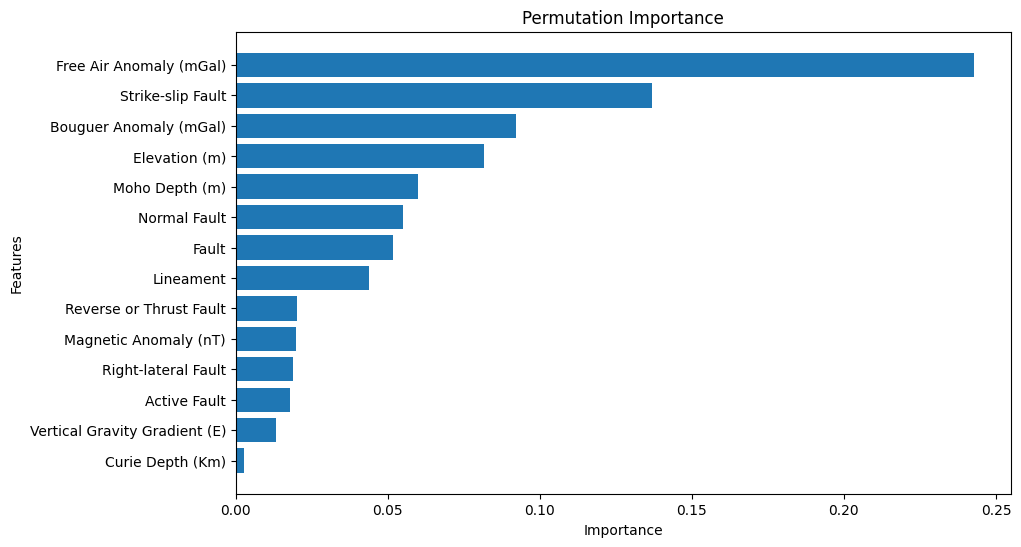

In [18]:
# Permutation Importance
perm_importance = permutation_importance(best_xgb_model, X_test, y_test, n_repeats=30, random_state=42)

# Plot permutation importance
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(range(X_test.shape[1]), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(X_test.shape[1]), X_test.columns[sorted_idx])
plt.title('Permutation Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

## Lasso Regression & Mutual Information

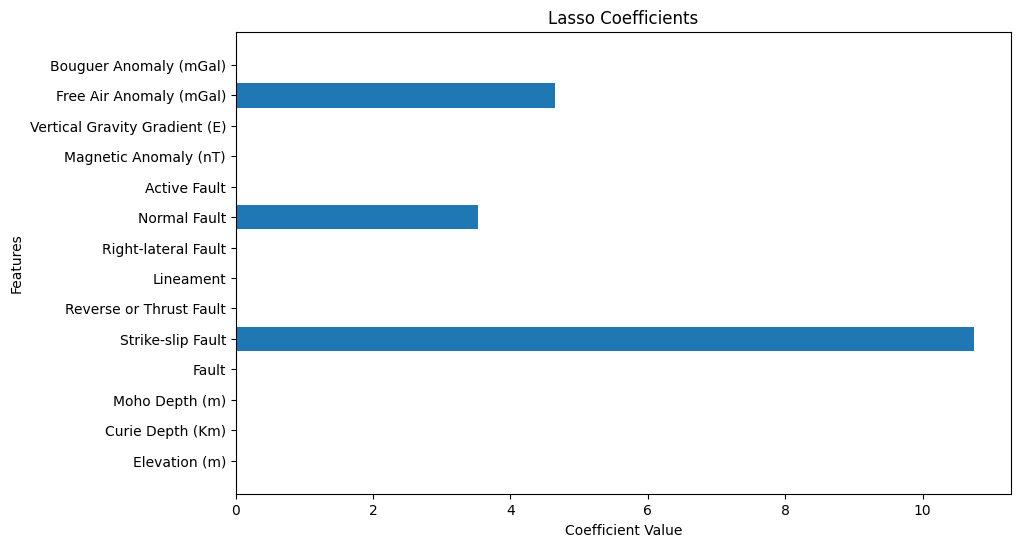

In [19]:
# Create and fit the Lasso regression model
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

# Get the coefficients and feature names
feature_coefficients = lasso_model.coef_
feature_names = X_train.columns

# Plot Lasso coefficients
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_coefficients)), feature_coefficients)
plt.yticks(range(len(feature_coefficients)), feature_names)  # Set feature names on y-axis
plt.title('Lasso Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

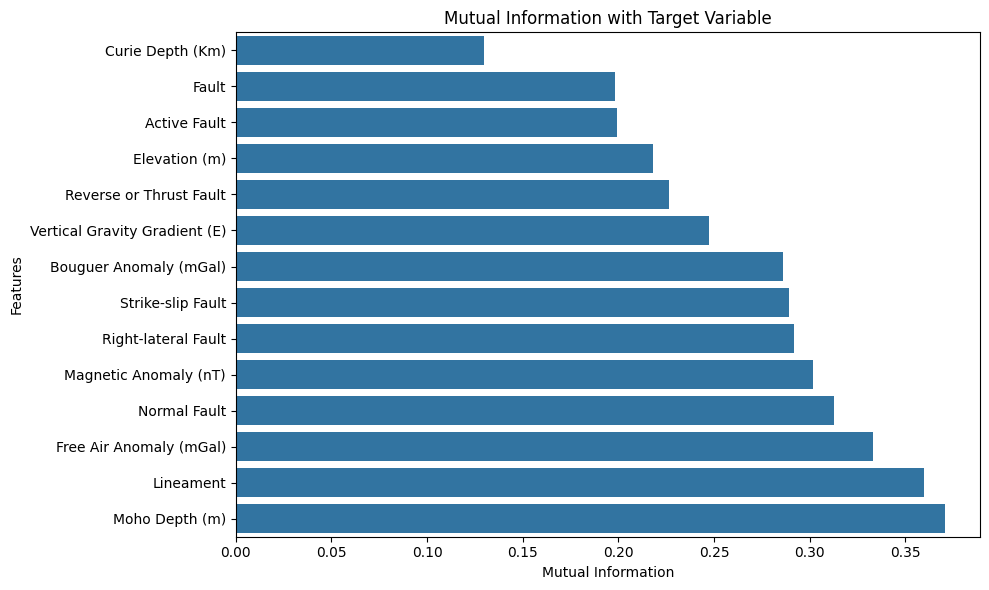

In [20]:
# Compute Mutual Information
mi = mutual_info_regression(X_train, y_train)

# Get the sorted indices (from lowest to highest mutual information)
sorted_indices = mi.argsort()

# Use the sorted indices to order the mutual information scores and feature names
sorted_mi = mi[sorted_indices]
sorted_feature_names = X_train.columns[sorted_indices]

# Plot mutual information
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_mi, y=sorted_feature_names)
plt.title('Mutual Information with Target Variable')
plt.xlabel('Mutual Information')
plt.ylabel('Features')
plt.tight_layout()  # Adjust layout to fit the figure neatly
plt.show()

## Regression results

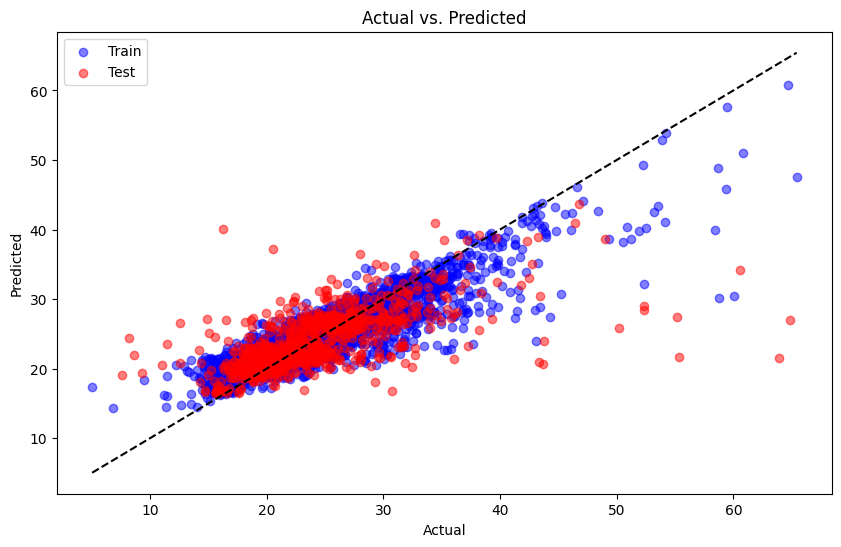

In [21]:
import matplotlib.pyplot as plt

# Use the model to make predictions on the training and test sets
y_train_pred = best_xgb_model.predict(X_train)
y_pred = best_xgb_model.predict(X_test)

# Create a scatter plot of the actual vs. predicted values for the training set
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, color='blue', label='Train', alpha=0.5)

# Create a scatter plot of the actual vs. predicted values for the test set
plt.scatter(y_test, y_pred, color='red', label='Test', alpha=0.5)

# Plot a line for perfect fit
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')

# Set the labels and title
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.legend()

# Show the plot
plt.show()

## Geospatial visualization

### Actual data

In [22]:
import geopandas as gpd

In [23]:
actual_data = pd.read_csv('normalized_data_minmax.csv')

In [24]:
actual_data.head()

,Latitude,Longitude,Elevation (m),Surface Temperature (°C),Apparent Geothermal Gradient (°C/Km),Moho Depth (m),Magnetic Anomaly (nT),Fault,Strike-slip Fault,Reverse or Thrust Fault,Lineament,Right-lateral Fault,Normal Fault,Active Fault,Curie Depth (Km),Vertical Gravity Gradient (E),Free Air Anomaly (mGal),Bouguer Anomaly (mGal)
0,4.213002,-74.893581,0.100752,0.899248,14.712281,0.720860,0.371683,0.055508,0.105702,0.021543,0.073640,0.100585,0.417515,0.035052,0.642857,0.341539,0.093121,0.241172
1,4.216078,-74.888898,0.100557,0.899443,21.294394,0.720455,0.371683,0.053527,0.104876,0.022877,0.075174,0.102181,0.418871,0.036250,0.642857,0.341539,0.093121,0.241172
2,4.214720,-74.891220,0.101535,0.898465,23.783404,0.720641,0.371683,0.054497,0.105307,0.022201,0.074422,0.101405,0.418205,0.035636,0.642857,0.341539,0.093121,0.241172
3,0.606276,-76.564731,0.088329,0.911671,24.156323,0.412171,0.524208,0.121886,0.170555,0.112310,0.283746,0.153212,0.761431,0.112189,0.357143,0.467743,0.309559,0.615321
4,0.305911,-76.914853,0.029052,0.970948,25.601245,0.483869,0.530678,0.126023,0.146573,0.097701,0.240410,0.232241,0.842979,0.105716,0.357143,0.460502,0.306293,0.628522


### Predicted data

In [25]:
# Make predictions using the entire dataset (X)
y_pred_full = best_xgb_model.predict(X)

# Update your existing DataFrame or create a new one to store the predictions
X_lat_lon['Predicted Geothermal Gradient (°C/Km)'] = y_pred_full

In [26]:
X_lat_lon.head()

,Latitude,Longitude,Predicted Geothermal Gradient (°C/Km)
0,4.213002,-74.893581,21.659538
1,4.216078,-74.888898,23.021467
2,4.214720,-74.891220,23.021467
3,0.606276,-76.564731,25.718042
4,0.305911,-76.914853,24.501291


In [27]:
X_lat_lon.to_csv('predicted_dataset.csv', index=False)

In [28]:
X_lat_lon = pd.read_csv('predicted_dataset.csv')

### Plot actual and predicted

/tmp/ipykernel_23395/1906445481.py:39: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


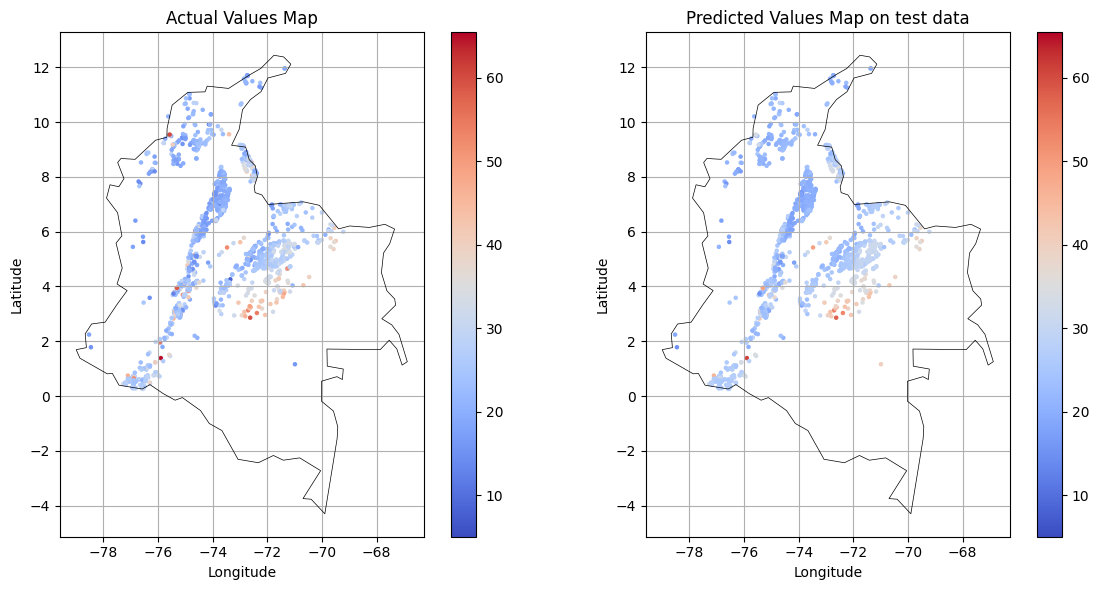

In [29]:
# Load GeoDataFrame for actual values
actual_gdf = gpd.GeoDataFrame(actual_data, geometry=gpd.points_from_xy(actual_data['Longitude'], actual_data['Latitude']))

# Load GeoDataFrame for predicted values
predicted_gdf = gpd.GeoDataFrame(X_lat_lon, geometry=gpd.points_from_xy(X_lat_lon['Longitude'], X_lat_lon['Latitude']))

# Determine the common color range
vmin = min(actual_gdf['Apparent Geothermal Gradient (°C/Km)'].min(), predicted_gdf['Predicted Geothermal Gradient (°C/Km)'].min())
vmax = max(actual_gdf['Apparent Geothermal Gradient (°C/Km)'].max(), predicted_gdf['Predicted Geothermal Gradient (°C/Km)'].max())

# Create subplots with two axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot actual values on the first subplot
actual_plot = actual_gdf.plot(column='Apparent Geothermal Gradient (°C/Km)', cmap='coolwarm', markersize=5, legend=True, ax=axes[0], vmin=vmin, vmax=vmax)
axes[0].set_title('Actual Values Map')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Plot predicted values on the second subplot
predicted_plot = predicted_gdf.plot(column='Predicted Geothermal Gradient (°C/Km)', cmap='coolwarm', markersize=5, legend=True, ax=axes[1], vmin=vmin, vmax=vmax)
axes[1].set_title('Predicted Values Map on test data')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

# Calculate grid positions based on min and max latitude and longitude
min_lon, max_lon = -78, -66
min_lat, max_lat = -4, 12
lon_grid = list(range(int(min_lon), int(max_lon) + 1, 2))
lat_grid = list(range(int(min_lat), int(max_lat) + 1, 2))

# Add gridlines for lat and lon to both subplots
for ax in axes:
    ax.set_xticks(lon_grid)
    ax.set_yticks(lat_grid)
    ax.grid()

# Load world country geometries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Subset the world dataset to only include countries within your area of interest
world = world.cx[-74:-73, 4:5]

# Plot country borders within your area of interest for both subplots
for ax in axes:
    world.boundary.plot(ax=ax, linewidth=0.5, color='black')

# Show the combined plot with both subplots
plt.tight_layout()
plt.show()


### Difference between actual and predicted

/tmp/ipykernel_23395/4261831172.py:23: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


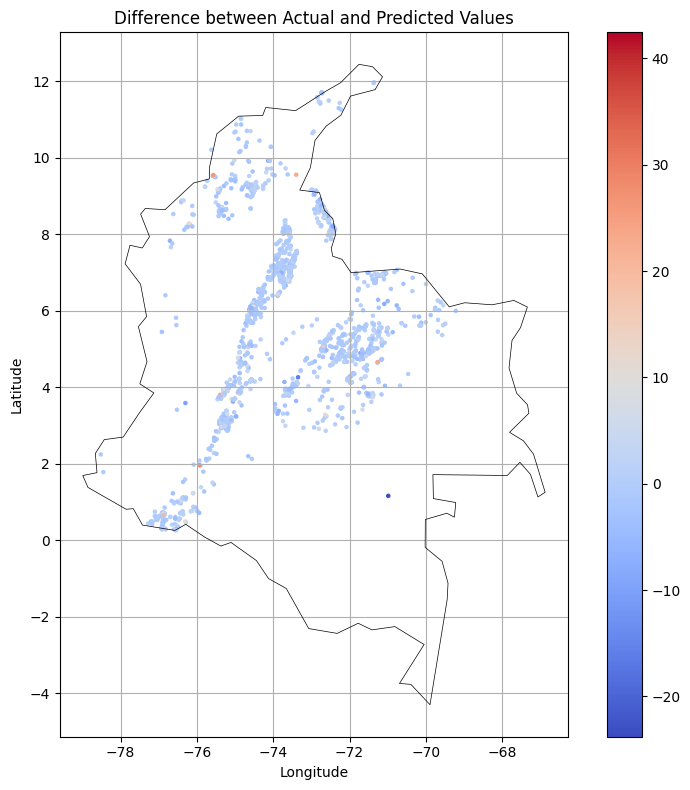

In [30]:
# Calculate the difference between actual and predicted values
actual_gdf['Apparent Geothermal Gradient (°C/Km)'] = actual_gdf['Apparent Geothermal Gradient (°C/Km)'] - predicted_gdf['Predicted Geothermal Gradient (°C/Km)']

# Create a plot for the difference values
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
difference_plot = actual_gdf.plot(column='Apparent Geothermal Gradient (°C/Km)', cmap='coolwarm', markersize=5, legend=True, ax=ax)
ax.set_title('Difference between Actual and Predicted Values')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Calculate grid positions based on min and max latitude and longitude
min_lon, max_lon = -78, -66
min_lat, max_lat = -4, 12
lon_grid = list(range(int(min_lon), int(max_lon) + 1, 2))
lat_grid = list(range(int(min_lat), int(max_lat) + 1, 2))

# Add gridlines for lat and lon
ax.set_xticks(lon_grid)
ax.set_yticks(lat_grid)
ax.grid()

# Load world country geometries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Subset the world dataset to only include countries within your area of interest
world = world.cx[-74:-73, 4:5]

# Plot country borders within your area of interest
world.boundary.plot(ax=ax, linewidth=0.5, color='black')

# Show the plot
plt.tight_layout()
plt.show()


## Feature influence

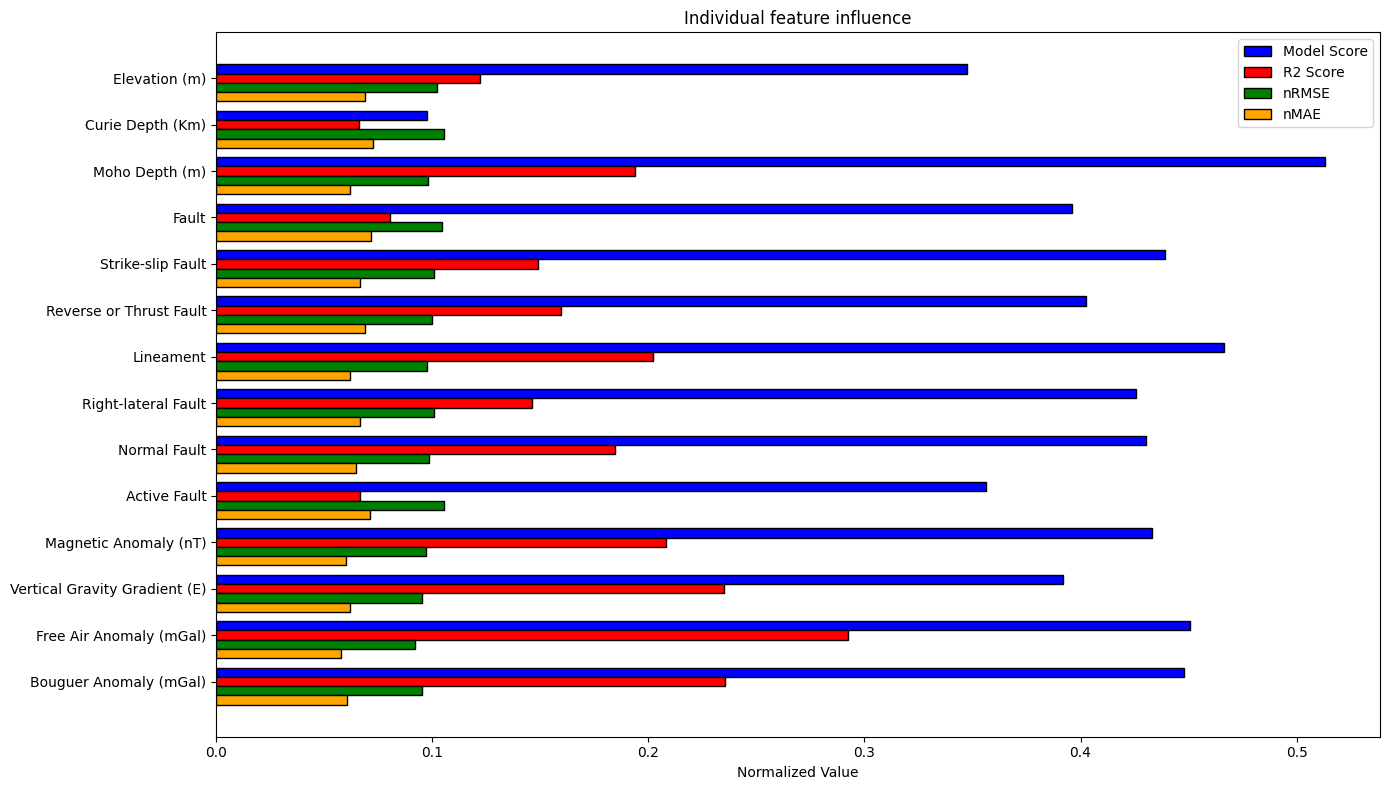

In [31]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Initialize lists to store results
features = []
training_scores = []
test_scores = []
nRMSEs = []
nMAEs = []

# Iterate over each feature in the dataset
for feature in X_train.columns:
    # Train the model using only this feature
    best_xgb_model.fit(X_train[[feature]], y_train)
    
    # Calculate the training score (model score)
    training_score = best_xgb_model.score(X_train[[feature]], y_train)
    training_scores.append(training_score)
    
    # Use the model to make predictions on the test set
    predictions = best_xgb_model.predict(X_test[[feature]])
    
    # Calculate the test score (R2 score)
    test_score = r2_score(y_test, predictions)
    test_scores.append(test_score)
    
    # Calculate the normalized Root Mean Square Error (nRMSE)
    nRMSE = np.sqrt(mean_squared_error(y_test, predictions)) / (y_test.max() - y_test.min())
    nRMSEs.append(nRMSE)
    
    # Calculate the normalized Mean Absolute Error (nMAE)
    nMAE = mean_absolute_error(y_test, predictions) / (y_test.max() - y_test.min())
    nMAEs.append(nMAE)
    
    # Store the feature name
    features.append(feature)

# Plot the results
plt.figure(figsize=(14, 8))
y_pos = np.arange(len(features))
bar_width = 0.2

# Plot each metric
plt.barh(y_pos, training_scores, bar_width, label='Model Score', color='b', edgecolor='black')
plt.barh(y_pos + bar_width, test_scores, bar_width, label='R2 Score', color='r', edgecolor='black')
plt.barh(y_pos + 2*bar_width, nRMSEs, bar_width, label='nRMSE', color='g', edgecolor='black')
plt.barh(y_pos + 3*bar_width, nMAEs, bar_width, label='nMAE', color='orange', edgecolor='black')

# Label axes and title
plt.xlabel('Normalized Value')
plt.yticks(y_pos + bar_width, features)
plt.title('Individual feature influence')
plt.legend()

# Display the plot
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.tight_layout()
plt.show()

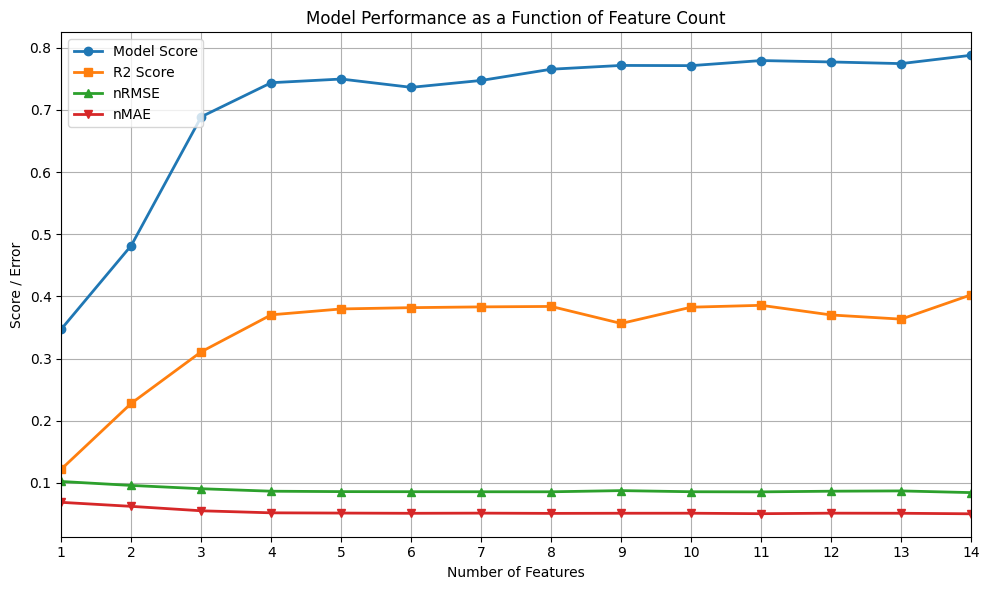

In [33]:
# Get feature importance by gain
importance = best_xgb_model.get_booster().get_score(importance_type='gain')

# Sort the features by their importance score
sorted_features = sorted(importance, key=importance.get, reverse=False)

# Now proceed with your existing code
num_features = []
training_scores = []
test_scores = []
nRMSEs = []
nMAEs = []

# Iterate over each feature in the sorted feature list
for i in range(len(sorted_features)):
    # Get the current feature and all previous features
    current_features = sorted_features[:i+1]
    
    # Train the model using these features
    best_xgb_model.fit(X_train[current_features], y_train)
    
    # Calculate the training score (model score)
    training_score = best_xgb_model.score(X_train[current_features], y_train)
    training_scores.append(training_score)
    
    # Use the model to make predictions on the test set
    predictions = best_xgb_model.predict(X_test[current_features])
    
    # Calculate the test score (R2 score)
    test_score = r2_score(y_test, predictions)
    test_scores.append(test_score)
    
    # Calculate the normalized Root Mean Square Error (nRMSE)
    nRMSE = np.sqrt(mean_squared_error(y_test, predictions)) / (y_test.max() - y_test.min())
    nRMSEs.append(nRMSE)
    
    # Calculate the normalized Mean Absolute Error (nMAE)
    nMAE = mean_absolute_error(y_test, predictions) / (y_test.max() - y_test.min())
    nMAEs.append(nMAE)
    
    # Store the number of features
    num_features.append(i+1)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(num_features, training_scores, label='Model Score', linewidth=2, marker='o')
plt.plot(num_features, test_scores, label='R2 Score', linewidth=2, marker='s')
plt.plot(num_features, nRMSEs, label='nRMSE', linewidth=2, marker='^')
plt.plot(num_features, nMAEs, label='nMAE', linewidth=2, marker='v')

# Enhance plot aesthetics
plt.title('Model Performance as a Function of Feature Count')
plt.xlabel('Number of Features')
plt.ylabel('Score / Error')
plt.xticks(range(1, len(sorted_features) + 1))  # Ensure x-axis ticks match feature counts
plt.grid(True)
plt.legend()

# Annotations and Axis Adjustments
max_feature_count = len(sorted_features)
plt.xlim(1, max_feature_count)
plt.xticks(np.arange(1, max_feature_count + 1, step=1))  # Adjust step based on feature count

plt.tight_layout()
plt.show()

## Load the model again

This is done as the feature influence modifies the model

In [34]:
best_xgb_model = joblib.load('trained_model.pkl')

# Predicting new values (Colombia)

We'll use a Colombia Cities Database to extract latitude and longitude data for the whole country (over 9000 geographic points)

## Generate random latitude and longitude points along the country

In [ ]:
import geopandas as gpd
import random
import pandas as pd
from shapely.geometry import Point
from tqdm import tqdm

# Load the shapefile for Colombia
colombia = gpd.read_file('data/COL_adm0.shp')

# Get the Polygon for Colombia
colombia_polygon = colombia.geometry.unary_union

# Define the bounding box of the polygon
bbox = colombia_polygon.bounds

# Number of random points to generate
num_points = 30000

# Generate random points within the bounding rectangle
random_points = []

while len(random_points) < num_points:
    random_lon = random.uniform(bbox[0], bbox[2])
    random_lat = random.uniform(bbox[1], bbox[3])
    random_point = Point(random_lon, random_lat)
    random_points.append({'Longitude': random_point.x, 'Latitude': random_point.y})

In [ ]:
# Create a list to store filtered points
filtered_points = []

progress_bar = tqdm(total=num_points, position=0)

# Filter points to keep only those within the Colombia shape
for point in tqdm(random_points, position=1, desc="Filtering Points"):
    if Point(point['Longitude'], point['Latitude']).within(colombia_polygon):
        filtered_points.append(point)
    progress_bar.update(1)

progress_bar.close()

# Create a DataFrame with the generated and filtered points
points = pd.DataFrame(filtered_points)

In [ ]:
points

In [ ]:
points.to_csv('points.csv', index = False)

In [ ]:
points = pd.read_csv('points.csv')

We'll add elevation/altitude to our dataframe using WorldDEM.tif. File elevation data is originally scaled 0-6400 meters.

In [ ]:
import rasterio
from pyproj import CRS, Transformer

# Rescale the elevation values to get actual values as they are downscaled 0-6400 meters
def rescale(val, in_min, in_max, out_min, out_max):
    return out_min + (val - in_min) * ((out_max - out_min) / (in_max - in_min))

def get_elevation(lat, lon, dem='data/WorldDEM.tif'):
    with rasterio.open(dem) as src:
        # Define coordinate systems
        in_crs = CRS("EPSG:4326")  # Input coordinate system (WGS84)
        out_crs = src.crs  # Output coordinate system (raster's crs)

        # Create a transformer object
        transformer = Transformer.from_crs(in_crs, out_crs, always_xy=True)

        # Transform coordinates
        lon, lat = transformer.transform(lon, lat)

        # Sample the raster at the transformed coordinates
        vals = src.sample([(lon, lat)])
        for val in vals:
            # Upscale the elevation value
            elevation = rescale(val[0], 0, 255, 0, 6400) # 0 and 255 are the min and max values of the DEM
    return elevation


# Use tqdm to show progress
tqdm.pandas()

# Apply the function to each row in your DataFrame
points['Elevation (m)'] = points.progress_apply(lambda row: get_elevation(row['Latitude'], row['Longitude']), axis=1)


## Now we need to do what we did before for Curie, Moho depht, etc; but for these data

### Moho depth

In [ ]:
from scipy.interpolate import griddata
from tqdm import tqdm

points_gdf = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points['Longitude'], points['Latitude']))
moho_depth_gdf = gpd.GeoDataFrame(moho_depth, geometry=gpd.points_from_xy(moho_depth['Lon'], moho_depth['Lat']))

# Convert GeoDataFrames to numpy arrays
points_array = points_gdf[['Longitude', 'Latitude']].values
moho_depth_array = moho_depth_gdf[['Lon', 'Lat', 'Moho Depth (m)']].values

# Separate the coordinates and values
coordinates, values = moho_depth_array[:, :2], moho_depth_array[:, 2]

# Initialize tqdm for progress bar
pbar = tqdm(total=len(points_array), desc="Interpolating", ncols=100)

# Initialize an empty list to store interpolated Moho depth values for each well
moho_depth_values = []

# Iterate through each well
for point in points_array:
    # Use griddata for interpolation
    moho_depth_value = griddata(coordinates, values, [point], method='cubic')
    
    # Append the interpolated Moho depth value to the list
    moho_depth_values.append(moho_depth_value[0])
    
    # Update the progress bar
    pbar.update()

# Close the progress bar
pbar.close()

# Add the interpolated Moho depth values to the "points" dataset as a new column
points['Moho Depth (m)'] = moho_depth_values

In [ ]:
points

### Magnetic Anomaly

In [ ]:
import rasterio
from rasterio.warp import transform

# Load the TIFF file
src = rasterio.open('data/Mag_anom_col.tif')

# Define a function to get the value from the TIFF file
def get_value_from_tiff(lat, lon):
    # Adjust longitudes greater than 180
    if lon > 180:
        lon = lon - 360
    # Transform lat, lon to the coordinate system of the tiff
    x, y = transform('EPSG:4326', src.crs, [lon], [lat])
    # Get the value at the transformed coordinate
    for val in src.sample([(x[0], y[0])]):
        return val[0]

# Apply the function to each row in the dataframe
points['Magnetic Anomaly (nT)'] = points.apply(lambda row: get_value_from_tiff(row['Latitude'], row['Longitude']), axis=1)

In [ ]:
points = points[(points['Magnetic Anomaly (nT)'] >= -363.13598632812) & 
                             (points['Magnetic Anomaly (nT)'] <= 548.34930419922)]

In [ ]:
points.to_csv('points_withoutoutliers.csv', index=False)

In [ ]:
points = pd.read_csv('points_withoutoutliers.csv')

In [ ]:
points.head()

### Curie Depth

In [ ]:
import rasterio
from rasterio.warp import transform

# Load the TIFF file
src = rasterio.open('data/Curie_depth.tif')

# Define a function to get the value from the TIFF file
def get_value_from_tiff(lat, lon):
    # Adjust longitudes greater than 180
    if lon > 180:
        
        lon = lon - 360
    # Transform lat, lon to the coordinate system of the tiff
    x, y = transform('EPSG:4326', src.crs, [lon], [lat])
    # Get the value at the transformed coordinate
    for val in src.sample([(x[0], y[0])]):
        return val[0]

# Apply the function to each row in the dataframe
points['Curie Depth (Km)'] = points.apply(lambda row: get_value_from_tiff(row['Latitude'], row['Longitude']), axis=1)

### Free Air

In [ ]:
src = rasterio.open('data/colombia_FAA_map.tif')

# Print the CRS
print(src.crs)

In [ ]:
import rasterio
from rasterio.warp import transform

# Load the TIFF file
src = rasterio.open('data/colombia_FAA_map.tif')

# Define a function to get the value from the TIFF file
def get_value_from_tiff(lat, lon):
    # Adjust longitudes greater than 180
    if lon > 180:
        lon = lon - 360
    # Transform lat, lon to the coordinate system of the tiff
    x, y = transform('EPSG:4326', src.crs, [lon], [lat])
    # Get the value at the transformed coordinate
    for val in src.sample([(x[0], y[0])]):
        return val[0]

# Apply the function to each row in the dataframe
points['FAA'] = points.apply(lambda row: get_value_from_tiff(row['Latitude'], row['Longitude']), axis=1)

In [ ]:
points.head()

### Vertical Gravity Gradient

In [ ]:
src = rasterio.open('data/colombia_gravity_map.tif')

# Print the CRS
print(src.crs)

In [ ]:
import rasterio
from rasterio.warp import transform

# Load the TIFF file
src = rasterio.open('data/colombia_gravity_map.tif')

# Define a function to get the value from the TIFF file
def get_value_from_tiff(lat, lon):
    # Adjust longitudes greater than 180
    if lon > 180:
        lon = lon - 360
    # Transform lat, lon to the coordinate system of the tiff
    x, y = transform('EPSG:4326', src.crs, [lon], [lat])
    # Get the value at the transformed coordinate
    for val in src.sample([(x[0], y[0])]):
        return val[0]

# Apply the function to each row in the dataframe
points['Gravity_gradient'] = points.apply(lambda row: get_value_from_tiff(row['Latitude'], row['Longitude']), axis=1)

In [ ]:
points.head()

### Bouguer anomaly

In [ ]:
src = rasterio.open('data/bouguer_col.tif')

# Print the CRS
print(src.crs)

In [ ]:
import rasterio
from rasterio.warp import transform

# Load the TIFF file
src = rasterio.open('data/bouguer_col.tif')

# Define a function to get the value from the TIFF file
def get_value_from_tiff(lat, lon):
    # Adjust longitudes greater than 180
    if lon > 180:
        lon = lon - 360
    # Transform lat, lon to the coordinate system of the tiff
    x, y = transform('EPSG:4326', src.crs, [lon], [lat])
    # Get the value at the transformed coordinate
    for val in src.sample([(x[0], y[0])]):
        return val[0]

# Apply the function to each row in the dataframe
points['Bouguer'] = points.apply(lambda row: get_value_from_tiff(row['Latitude'], row['Longitude']), axis=1)

In [ ]:
points.head()

In [ ]:
points.rename(columns={
        'Gravity_gradient': 'Vertical Gravity Gradient (E)',
        'FAA': 'Free Air Anomaly (mGal)',
        'Bouguer': 'Bouguer Anomaly (mGal)'}, inplace=True)

In [ ]:
points.columns

We'll remove insular points

In [ ]:
# Define the latitude and longitude bounds
min_lon, max_lon = -79, -67
min_lat, max_lat = -4, 13

# Create a boolean mask to filter the rows within the specified bounds
mask = (points['Longitude'] >= min_lon) & (points['Longitude'] <= max_lon) & (points['Latitude'] >= min_lat) & (points['Latitude'] <= max_lat)

# Apply the mask to filter the rows
points = points[mask]

### Fault Proximity

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points
from tqdm import tqdm  # Import tqdm for the progress bar
import pandas as pd

# Load the shapefile
faults = gpd.read_file('data/Faults/faults.shp')

# Ensure the shapefile is in the correct coordinate system
faults = faults.to_crs('EPSG:3116')

# Create a GeoDataFrame from your dataset
# Replace 'Latitude' and 'Longitude' with your actual column names
gdf = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points.Longitude, points.Latitude), crs='EPSG:4326')

# Convert the GeoDataFrame to the same coordinate system as the shapefile
gdf = gdf.to_crs('EPSG:3116')

# Initialize an empty GeoDataFrame to store the distances
distances = gpd.GeoDataFrame()

# Loop through each point in the GeoDataFrame with tqdm for the progress bar
for index, row in tqdm(gdf.iterrows(), total=len(gdf), desc="Calculating Nearest Faults"):
    # Find the nearest fault of each type for the current point
    nearest_fault = {}
    for fault_type in faults['Tipo'].unique():
        faults_of_type = faults[faults['Tipo'] == fault_type].copy()
        faults_of_type['geometry'] = faults_of_type['geometry'].centroid
        faults_of_type = faults_of_type.set_geometry('geometry')
        faults_of_type = faults_of_type.unary_union
        nearest = nearest_points(row['geometry'], faults_of_type)[1]
        nearest_fault[fault_type] = nearest.distance(row['geometry'])
    # Append the nearest faults to the GeoDataFrame
    distances = pd.concat([distances, gpd.GeoDataFrame(nearest_fault, index=[index])])

# Add the new columns to the original DataFrame
points = pd.concat([points, distances], axis=1)

In [ ]:
# List of fault types including "Lineamiento"
fault_types = ['Falla', 'Falla de rumbo sinestral', 'Falla inversa o de cabalgamiento', 'Lineamiento', 'Falla de rumbo dextral', 'Falla normal']

# Iterate through each fault type
for fault_type in fault_types:
    # Skip the consolidation process for "Lineamiento"
    if fault_type == 'Lineamiento':
        continue
    
    # Create a new column with the minimum distance among the original, 'cubierta', and 'inferida' columns
    points[fault_type] = points[[f'{fault_type} cubierta', f'{fault_type} inferida', fault_type]].min(axis=1)

    # Drop the redundant 'cubierta' and 'inferida' columns
    points = points.drop([f'{fault_type} cubierta', f'{fault_type} inferida'], axis=1)

In [ ]:
# Define a mapping of old column names to new column names
column_mapping = {
    'Falla': 'Fault',
    'Falla de rumbo sinestral': 'Strike-slip Fault',
    'Falla inversa o de cabalgamiento': 'Reverse or Thrust Fault',
    'Lineamiento': 'Lineament',
    'Falla de rumbo dextral': 'Right-lateral Fault',
    'Falla normal': 'Normal Fault'
}


# Rename columns
points.rename(columns=column_mapping, inplace=True)

### Active faults

In [ ]:
import geopandas as gpd
from shapely.ops import nearest_points
from tqdm import tqdm
import pandas as pd

# Load the active faults shapefile
active_faults_path = 'data/Faults/Active/ATA.shp'
active_faults = gpd.read_file(active_faults_path)
active_faults = active_faults.to_crs('EPSG:3116')


# Create a GeoDataFrame from your dataset
# Replace 'Latitude' and 'Longitude' with your actual column names
gdf = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points.Longitude, points.Latitude), crs='EPSG:4326')

# Convert the GeoDataFrame to the same coordinate system as the active faults
gdf = gdf.to_crs(active_faults.crs)

# Initialize an empty DataFrame to store distances to active faults
active_faults_distances = pd.DataFrame()

# Loop through each point in the GeoDataFrame with tqdm for the progress bar
for index, row in tqdm(gdf.iterrows(), total=len(gdf), desc="Calculating Distances to Active Faults"):
    # Find the nearest active fault for the current point
    nearest_active_fault = nearest_points(row['geometry'], active_faults.unary_union)[1]
    
    # Calculate the distance and store it in the DataFrame
    distance_to_active_fault = nearest_active_fault.distance(row['geometry'])
    active_faults_distances.at[index, 'Active Fault'] = distance_to_active_fault

# Add the new column to the original DataFrame
points = pd.concat([points, active_faults_distances], axis=1)

In [ ]:
points.to_csv('full_prediction_points.csv', index=False)

In [ ]:
points = pd.read_csv('full_prediction_points.csv')
points.head()

## Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

columns_to_normalize = ['Elevation (m)', 'Moho Depth (m)', 
       'Curie Depth (Km)', 'Fault', 'Strike-slip Fault',
       'Reverse or Thrust Fault', 'Lineament', 'Right-lateral Fault',
       'Normal Fault', 'Active Fault', 'Magnetic Anomaly (nT)',
       'Vertical Gravity Gradient (E)', 'Free Air Anomaly (mGal)',
       'Bouguer Anomaly (mGal)']

# Initialize the Min-Max scaler
scaler = MinMaxScaler()

# Fit and transform the selected columns
points[columns_to_normalize] = scaler.fit_transform(points[columns_to_normalize])

# Save the normalized data to a new CSV file
points.to_csv('normalized_full_prediction.csv', index=False)

In [35]:
points = pd.read_csv('normalized_full_prediction.csv')
points.head()

,Longitude,Latitude,Elevation (m),Moho Depth (m),Magnetic Anomaly (nT),Curie Depth (Km),Free Air Anomaly (mGal),Vertical Gravity Gradient (E),Bouguer Anomaly (mGal),Fault,Strike-slip Fault,Reverse or Thrust Fault,Lineament,Right-lateral Fault,Normal Fault,Active Fault
0,-74.794856,0.111833,0.042328,0.285085,0.604210,0.642857,0.139375,0.251871,0.397807,0.266546,0.308912,0.196042,0.075754,0.214496,0.428156,0.264893
1,-68.287650,4.736540,0.021164,0.444411,0.645887,0.571429,0.124705,0.264107,0.383486,0.226731,0.133889,0.505402,0.383612,0.131062,0.329133,0.266846
2,-71.942279,2.436080,0.037037,0.359088,0.775058,0.857143,0.168955,0.261018,0.442627,0.120519,0.248059,0.250351,0.180583,0.257368,0.286651,0.303053
3,-72.123881,-0.423472,0.037037,0.290403,0.410328,0.785714,0.174712,0.263839,0.450150,0.490443,0.457458,0.439029,0.104542,0.469740,0.600280,0.511041
4,-74.030652,9.612854,0.015873,0.531744,0.547240,0.500000,0.095775,0.252227,0.335302,0.060130,0.028778,0.047006,0.328612,0.076047,0.296188,0.048054


## Prediction

In [37]:
selected_features = ['Elevation (m)', 'Curie Depth (Km)',
       'Moho Depth (m)', 'Fault', 'Strike-slip Fault',
       'Reverse or Thrust Fault', 'Lineament', 'Right-lateral Fault',
       'Normal Fault', 'Active Fault', 'Magnetic Anomaly (nT)',
       'Vertical Gravity Gradient (E)', 'Free Air Anomaly (mGal)',
       'Bouguer Anomaly (mGal)']

# Create a new DataFrame with the selected columns
selected_data = points[selected_features]

X_new = selected_data.values  # Convert the DataFrame to a 2D numpy array

# Use the XGBoost model to make predictions
y_pred_new = best_xgb_model.predict(X_new)

# Add the predicted values to the points DataFrame
points['Predicted Geothermal Gradient (°C/Km)'] = y_pred_new


In [38]:
points.to_csv('predicted_new.csv', index=False)

In [39]:
predicted_new = pd.read_csv('predicted_new.csv')
predicted_new.head()

,Longitude,Latitude,Elevation (m),Moho Depth (m),Magnetic Anomaly (nT),Curie Depth (Km),Free Air Anomaly (mGal),Vertical Gravity Gradient (E),Bouguer Anomaly (mGal),Fault,Strike-slip Fault,Reverse or Thrust Fault,Lineament,Right-lateral Fault,Normal Fault,Active Fault,Predicted Geothermal Gradient (°C/Km)
0,-74.794856,0.111833,0.042328,0.285085,0.604210,0.642857,0.139375,0.251871,0.397807,0.266546,0.308912,0.196042,0.075754,0.214496,0.428156,0.264893,23.019539
1,-68.287650,4.736540,0.021164,0.444411,0.645887,0.571429,0.124705,0.264107,0.383486,0.226731,0.133889,0.505402,0.383612,0.131062,0.329133,0.266846,20.942850
2,-71.942279,2.436080,0.037037,0.359088,0.775058,0.857143,0.168955,0.261018,0.442627,0.120519,0.248059,0.250351,0.180583,0.257368,0.286651,0.303053,21.141533
3,-72.123881,-0.423472,0.037037,0.290403,0.410328,0.785714,0.174712,0.263839,0.450150,0.490443,0.457458,0.439029,0.104542,0.469740,0.600280,0.511041,24.814438
4,-74.030652,9.612854,0.015873,0.531744,0.547240,0.500000,0.095775,0.252227,0.335302,0.060130,0.028778,0.047006,0.328612,0.076047,0.296188,0.048054,21.025797


<Axes: xlabel='Predicted Geothermal Gradient (°C/Km)', ylabel='Count'>

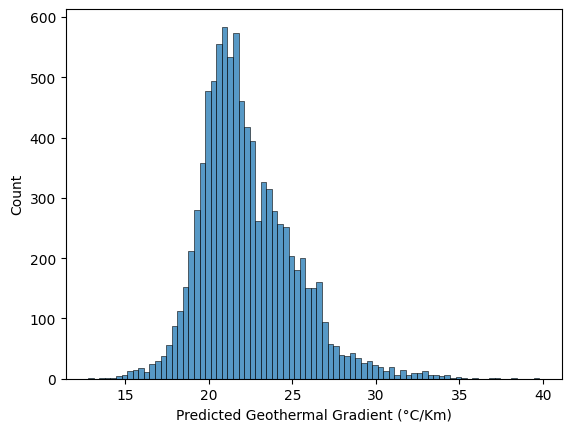

In [40]:
sns.histplot(predicted_new['Predicted Geothermal Gradient (°C/Km)'], kde=False)

### Plot map

/tmp/ipykernel_23395/2277474893.py:32: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


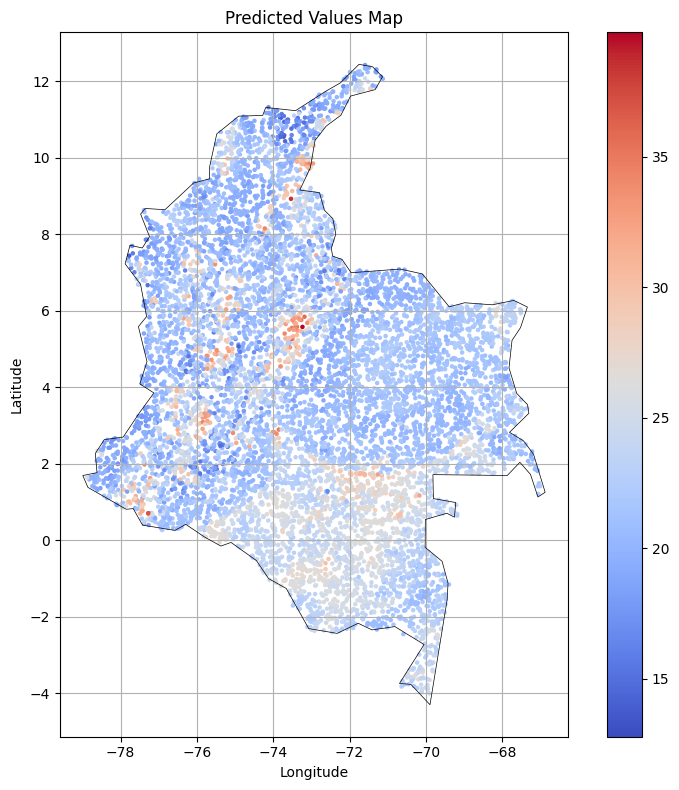

In [41]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the GeoDataFrame for predicted values
predicted_gdf = gpd.GeoDataFrame(predicted_new, geometry=gpd.points_from_xy(predicted_new['Longitude'], predicted_new['Latitude']))

# Determine the color range
vmin = predicted_gdf['Predicted Geothermal Gradient (°C/Km)'].min()
vmax = predicted_gdf['Predicted Geothermal Gradient (°C/Km)'].max()

# Create a subplot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the predicted values
predicted_plot = predicted_gdf.plot(column='Predicted Geothermal Gradient (°C/Km)', cmap='coolwarm', markersize=5, legend=True, ax=ax)
ax.set_title('Predicted Values Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Calculate grid positions based on your data's latitude and longitude
min_lon, max_lon = -78, -66
min_lat, max_lat = -4, 12
lon_grid = list(range(int(min_lon), int(max_lon) + 1, 2))
lat_grid = list(range(int(min_lat), int(max_lat) + 1, 2))

# Add gridlines for latitude and longitude
ax.set_xticks(lon_grid)
ax.set_yticks(lat_grid)
ax.grid()

# Load world country geometries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Subset the world dataset to only include countries within your area of interest
world = world.cx[-74:-73, 4:5]

# Plot country borders within your area of interest
world.boundary.plot(ax=ax, linewidth=0.5, color='black')

# Show the plot
plt.tight_layout()
plt.show()